## 3.2 Least-Squares Fitting

Experimental (and numerical!) data typically contain “scatter” due to experimental
errors, numerical inaccuracies, and other sources of uncertainty. Therefore, data
should be described by a *best fit* — a smooth function that captures the overall
trend — without requiring the fitted curve to pass exactly through every data point.

- **Aim:**  
  Find a functional form $( f(x; p_1, p_2, \ldots, p_k) \$ which best approximates
  the measured data points $((x_1, y_1), (x_2, y_2), \ldots, (x_N, y_N)$).

- **Method:**  
  Evaluate the total deviation between the “functional guess” $f(x) $ and the measured data $(x_i, y_i)$
  by computing the **sum of squared residuals**:

  $
  S = \sum_{i=1}^{N} \left[ f(x_i; p_1, p_2, \ldots, p_k) - y_i \right]^2.
  $

- **Best fit:**  
  The optimal parameters $(p_1, \ldots, p_k)$ are chosen such that $S$ is minimised:

  $
  \frac{\partial S}{\partial p_j} = 0, \qquad j = 1, 2, \ldots, k.
  $

This minimisation principle yields a system of equations (often linear in the parameters)
whose solution defines the least-squares best fit to the data.


## 3.2.1 Linear Regression

### Example: Constant Velocity Fit

Consider a moving object for which we measure its position \( x_i \) as a function of time \( t_i \).
From \( N \) measurements, we *guess* (based on some prior experience) that the velocity is constant.
Our aim is to determine this velocity.

- **Functional guess:**

  $$x(t) = a + bt \tag{3.5}$$

- **Sum of squared residuals:**

  $$S = \sum_{i=1}^{N} \big( x(t_i) - x_i \big)^2$$

- **Minimisation of \( S \)** with respect to the fit parameters \( a \) and \( b \):

  $$\frac{\partial S}{\partial a} := 0, \qquad \frac{\partial S}{\partial b} := 0 \tag{3.6}$$

---

Taking derivatives explicitly:

$$
\frac{\partial S}{\partial a}
= 2 \sum_{i=1}^{N} (x(t_i) - x_i) \frac{\partial x}{\partial a}\bigg|_{t=t_i}
= 2 \sum_{i=1}^{N} (a + b t_i - x_i) := 0
\tag{3.7}
$$

Since  
$$\frac{\partial^2 S}{\partial a^2} = 2N > 0,$$  
this corresponds to a **minimum**.

Similarly,

$$
\frac{\partial S}{\partial b}\bigg|_{t=t_i}
= 2 \sum_{i=1}^{N} (a + b t_i - x_i)t_i := 0
\tag{3.8}
$$

and

$$
\frac{\partial^2 S}{\partial b^2}
= 2 \sum_{i=1}^{N} t_i^2 > 0,
$$

which again confirms a **minimum** in \( S \) with respect to \( b \).


In [1]:
import numpy as np

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def lagrange_interp(x, y, xq):
    """
    Global Lagrange interpolation:
      p(x) = sum_j y_j * L_j(x), with
      L_j(x) = prod_{i!=j} (x - x_i) / (x_j - x_i)
    Works for scalar or array xq.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.ndim != 1 or y.ndim != 1 or x.size != y.size:
        raise ValueError("x and y must be 1D arrays of the same length.")
    if np.unique(x).size != x.size:
        raise ValueError("All x values must be distinct.")

    xq = np.asarray(xq, dtype=float)
    xq_flat = xq.ravel()

    n = x.size
    # Precompute denominators for each L_j
    denom = np.ones(n, dtype=float)
    for j in range(n):
        denom[j] = np.prod(x[j] - np.delete(x, j))

    # Evaluate p(xq)
    p_vals = np.zeros_like(xq_flat, dtype=float)
    for j in range(n):
        num = np.ones_like(xq_flat)
        for xi in np.delete(x, j):
            num *= (xq_flat - xi)
        Lj = num / denom[j]
        p_vals += y[j] * Lj

    return p_vals.reshape(xq.shape)

def local_quadratic_interp_piecewise(x, y, xq):
    """
    Piecewise 3-point quadratic interpolation.
    For each xq, pick a center index with neighbors on both sides,
    then do 3-point Lagrange on that local triplet.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    xq = np.asarray(xq, dtype=float)

    # Ensure strictly increasing x for interval logic
    order = np.argsort(x)
    x, y = x[order], y[order]
    n = len(x)
    if n < 3:
        raise ValueError("Need at least 3 points for local quadratic interpolation.")

    yq = np.empty_like(xq, dtype=float)
    for idx, xv in np.ndenumerate(xq):
        i = np.searchsorted(x, xv) - 1
        i = max(0, min(i, n - 2))      # clamp to valid interval
        i_center = min(max(i, 1), n - 2)
        tri = [i_center - 1, i_center, i_center + 1]
        yq[idx] = lagrange_interp(x[tri], y[tri], xv)
    return yq


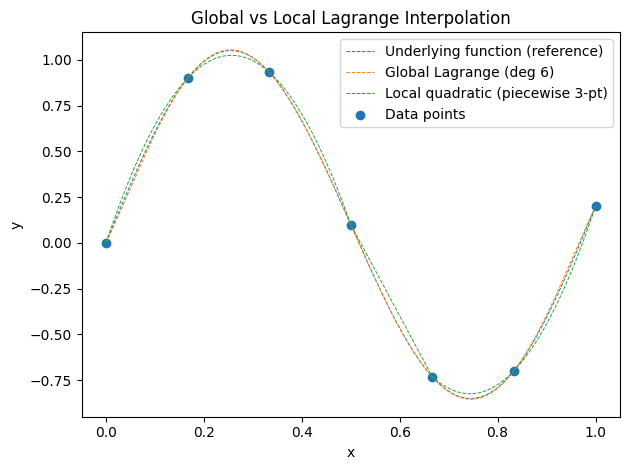

In [3]:
# ---- Replace xs, ys with YOUR data points ----
# Example data sampled from a smooth function:
f = lambda t: np.sin(2 * np.pi * t) + 0.2 * t
xs = np.linspace(0.0, 1.0, 7)
ys = f(xs)

# Dense grid for plotting
xplot = np.linspace(xs.min(), xs.max(), 400)

# Global (degree n-1) interpolant and local piecewise quadratic
y_global = lagrange_interp(xs, ys, xplot)
y_local  = local_quadratic_interp_piecewise(xs, ys, xplot)

# Plot (single figure, default colors)
plt.figure()
plt.plot(xplot, f(xplot), label="Underlying function (reference)", linewidth=0.7, linestyle='dashed')
plt.plot(xplot, y_global, label=f"Global Lagrange (deg {len(xs)-1})", linewidth=0.7, linestyle='dashed')
plt.plot(xplot, y_local,  label="Local quadratic (piecewise 3-pt)", linewidth=0.7, linestyle='dashed')
plt.scatter(xs, ys, label="Data points")
plt.title("Global vs Local Lagrange Interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

**Version to apply to large dataset with multipe windows**


In [4]:
import numpy as np

def _barycentric_weights(x):
    """
    Compute first-form barycentric weights:
        w_j = 1 / prod_{m!=j} (x_j - x_m)
    Works for small k (here k=4).
    """
    x = np.asarray(x, dtype=float)
    k = len(x)
    w = np.ones(k, dtype=float)
    for j in range(k):
        diff = x[j] - np.delete(x, j)
        w[j] = 1.0 / np.prod(diff)
    return w

def _barycentric_eval(x_nodes, y_nodes, w, xq):
    """
    Evaluate barycentric Lagrange interpolant at xq (scalar or array).
    Uses:
        p(x) = sum_j [ w_j * y_j / (x - x_j) ] / sum_j [ w_j / (x - x_j) ]
    with exact hit handling when x == x_j.
    """
    x_nodes = np.asarray(x_nodes, dtype=float)
    y_nodes = np.asarray(y_nodes, dtype=float)
    w = np.asarray(w, dtype=float)
    xq = np.asarray(xq, dtype=float)

    # Broadcast for vectorized evaluation
    X = xq[..., None]  # shape (..., 1)
    diff = X - x_nodes  # shape (..., k)

    # Handle exact nodes: if xq equals some x_j, return y_j exactly
    hit = np.isclose(diff, 0.0)
    any_hit = hit.any(axis=-1)
    out = np.empty(xq.shape, dtype=float)

    # Regular barycentric formula for the others
    safe = ~any_hit
    if np.any(safe):
        diff_safe = diff[safe]
        num = np.sum((w * y_nodes) / diff_safe, axis=-1)
        den = np.sum(w / diff_safe, axis=-1)
        out[safe] = num / den

    # Exact hits: pick the matching y_j
    if np.any(any_hit):
        idx_hit = np.argmax(hit[any_hit], axis=-1)
        out[any_hit] = y_nodes[idx_hit]

    return out

def partition_x_into_groups_of_4_from_end(x):
    """
    Partition the x array into non-overlapping groups of 4,
    starting from the last (rightmost) value.

    Returns a list of dicts, each with:
      - 'label' : 'group_1_from_end', 'group_2_from_end', ...
      - 'x'     : the group's x-values (4 or fewer in the leftmost group)
      - 'idx'   : the original indices for that group
    """
    x = np.asarray(x)
    n = len(x)
    groups = []
    group_num = 1

    i = n
    while i > 0:
        start = max(0, i - 4)
        idx = np.arange(start, i)
        groups.append({
            "label": f"group_{group_num}_from_end",
            "x": x[idx],
            "idx": idx
        })
        group_num += 1
        i -= 4

    # Optional: reverse so first group corresponds to the leftmost part (natural reading order)
    groups.reverse()
    return groups

class PiecewiseCubicLagrange:
    """
    Piecewise degree-3 (4-point) Lagrange interpolant.

    For each interval [x[i], x[i+1]], we choose a window of 4 nodes:
        [i-1, i, i+1, i+2] (clamped at the ends),
    build a local cubic via barycentric weights, and use it only on that interval.
    This yields a single continuous function across all nodes.
    """

    def __init__(self, x, y):
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)
        if x.ndim != 1 or y.ndim != 1 or len(x) != len(y):
            raise ValueError("x and y must be 1D arrays of the same length.")
        if len(x) < 4:
            raise ValueError("Need at least 4 data points for 4-point interpolation.")
        # Sort by x, require strictly increasing
        order = np.argsort(x)
        self.x = x[order]
        self.y = y[order]
        if np.any(np.diff(self.x) <= 0):
            raise ValueError("x values must be strictly increasing (no duplicates).")

        n = len(self.x)
        # Precompute per-interval windows and barycentric weights
        # intervals: i = 0 .. n-2, domain pieces [x[i], x[i+1]]
        self.windows = []  # list of dicts: { 'idx': idx_window, 'xw':..., 'yw':..., 'w':... }
        for i in range(n - 1):
            # centered window [i-1, i, i+1, i+2] with clamping
            i0 = max(0, min(i - 1, n - 4))
            idx = np.arange(i0, i0 + 4)  # 4 consecutive indices
            xw = self.x[idx]
            yw = self.y[idx]
            w = _barycentric_weights(xw)
            self.windows.append({'idx': idx, 'xw': xw, 'yw': yw, 'w': w})

    def __call__(self, xq):
        """
        Evaluate the stitched piecewise cubic at xq (scalar or array).
        """
        xq = np.asarray(xq, dtype=float)
        out = np.empty_like(xq, dtype=float)

        # For each xq, find its interval and evaluate using that interval's local cubic
        n = len(self.x)
        i = np.searchsorted(self.x, xq) - 1
        i = np.clip(i, 0, n - 2)

        # Vectorized: group by unique intervals
        for i_val in np.unique(i):
            mask = (i == i_val)
            win = self.windows[i_val]
            out[mask] = _barycentric_eval(win['xw'], win['yw'], win['w'], xq[mask])

        return out

    def interval_windows(self):
        """Return a list of (interval [x_i, x_{i+1}], window indices) for inspection."""
        info = []
        for i, win in enumerate(self.windows):
            info.append(((self.x[i], self.x[i+1]), win['idx'].copy()))
        return info

    # NEW: expose the x-only partitioning from *this object's* sorted x
    def x_groups_of_4_from_end(self):
        """
        Partition self.x into non-overlapping groups of 4 starting from the end.
        Returns the same structure as partition_x_into_groups_of_4_from_end(self.x).
        """
        return partition_x_into_groups_of_4_from_end(self.x)


# ---------------- Example (minimal) ----------------
if __name__ == "__main__":
    f = lambda t: np.sinc(t / np.pi)  # stable sin(t)/t
    xs = np.linspace(-15, 15, 24)
    ys = f(xs)

    interp = PiecewiseCubicLagrange(xs, ys)

    # Get x-only groups of 4 from the end:
    x_groups = interp.x_groups_of_4_from_end()
    for g in x_groups:
        print(f"{g['label']}: idx={g['idx']}, x={np.round(g['x'], 3)}")


group_6_from_end: idx=[0 1 2 3], x=[-15.    -13.696 -12.391 -11.087]
group_5_from_end: idx=[4 5 6 7], x=[-9.783 -8.478 -7.174 -5.87 ]
group_4_from_end: idx=[ 8  9 10 11], x=[-4.565 -3.261 -1.957 -0.652]
group_3_from_end: idx=[12 13 14 15], x=[0.652 1.957 3.261 4.565]
group_2_from_end: idx=[16 17 18 19], x=[5.87  7.174 8.478 9.783]
group_1_from_end: idx=[20 21 22 23], x=[11.087 12.391 13.696 15.   ]


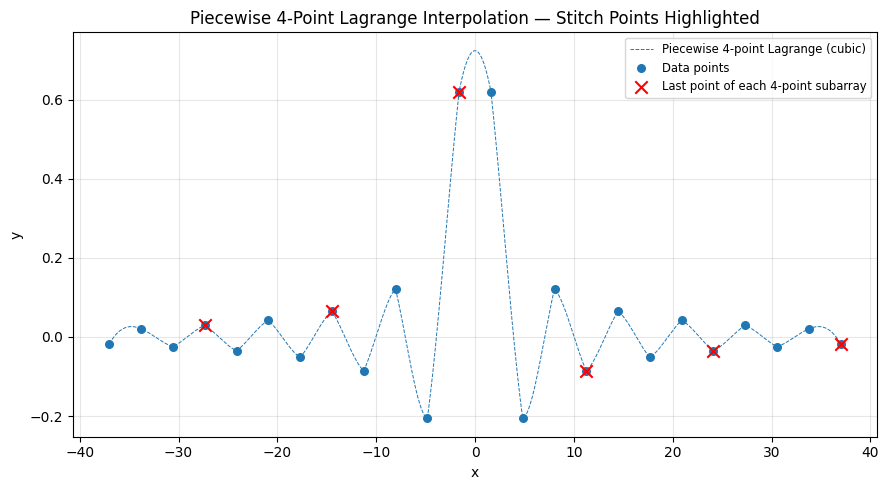

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
f = lambda t: np.sinc(t / np.pi)  # sin(t)/t but stable at 0
xs = np.linspace(-37, 37, 24)
ys = f(xs)

# Build interpolant (assumes PiecewiseCubicLagrange is already defined)
interp = PiecewiseCubicLagrange(xs, ys)

# Evaluate smooth curve
xq = np.linspace(xs.min(), xs.max(), 800)
yq = interp(xq)

# Base plot
plt.figure(figsize=(9, 5))
plt.plot(xq, yq, "--", linewidth=0.7, label='Piecewise 4-point Lagrange (cubic)')
plt.scatter(xs, ys, label='Data points', s=30, zorder=3)

# --- Stitch points (where the 4-point window changes) ---
change_x = []
wins = interp.interval_windows()  # list of ((a,b), idx_array)

# Compare consecutive windows; when they differ, mark the boundary x_{i+1}
for i in range(len(wins) - 1):
    idx_i    = tuple(np.asarray(wins[i][1]).tolist())
    idx_next = tuple(np.asarray(wins[i+1][1]).tolist())
    if idx_i != idx_next:
        boundary_x = wins[i][0][1]  # right endpoint of interval i
        change_x.append(boundary_x)

# --- Red markers at the last point of each 4-point sub-array ---
groups = interp.x_groups_of_4_from_end()

# Collect the last x of each group
change_x = [g["x"][-1] for g in groups]
change_x = np.array(change_x, dtype=float)
change_y = interp(change_x)

# Plot red "x" markers at those last points
plt.scatter(
    change_x, change_y,
    marker="x", s=80, color="red",
    label="Last point of each 4-point subarray", zorder=5
)


# Styling
plt.title("Piecewise 4-Point Lagrange Interpolation — Stitch Points Highlighted")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
